In [1]:
import matplotlib.pyplot as plt

import scipy.io
from sort import *
import numpy as np
import cv2
import pandas as pd
import ffmpeg
from tqdm.notebook import trange, tqdm
from collections import defaultdict
import json

In [2]:
pd_dataframe = pd.read_csv("data/au-currumbin4k.stream.20200608T000955960.detections.csv")

In [3]:
unique_times = np.sort(np.unique(pd_dataframe["timestamp"].to_numpy()))

In [4]:
pd_dataframe["frames_indx"] = 0
for i in range(len(unique_times)):
    pd_dataframe.loc[pd_dataframe['timestamp'] == unique_times[i], 'frames_indx'] = i

In [5]:
# Remove all non-surfers
pd_dataframe = pd_dataframe.drop(pd_dataframe[pd_dataframe["class"] < 5].index)

In [6]:
#create instance of SORT
mot_tracker = Sort(max_age=10, iou_threshold=0.1)

In [7]:
tracks_logger = {}
trajectory_logger = defaultdict(lambda: {"timestamps": [],
                                         "bounding_boxes": [], 
                                         "centroid": [], 
                                         "velocities": [],
                                         "number_of_detections": 0})

bb_x_size = 128
bb_y_size = 64

x_size = 3840
y_size = 2160

for i in range(pd_dataframe['frames_indx'].max() + 1):
    frame_detections = pd_dataframe[pd_dataframe['frames_indx'] == i]
    if len(frame_detections) > 0:
        centroid_x = (frame_detections["x0"] + (frame_detections["x1"] - frame_detections["x0"])/2).to_numpy()
        centroid_y = (frame_detections["y0"] + (frame_detections["y1"] - frame_detections["y0"])/2).to_numpy()
        
        centroid_x *= x_size
        centroid_y *= y_size

        score = frame_detections["confidence"].to_numpy()
        
        original_bbox = np.stack([frame_detections["x0"].to_numpy() * x_size, 
                                   frame_detections["y0"].to_numpy() * y_size,
                                   frame_detections["x1"].to_numpy() * x_size, 
                                   frame_detections["y1"].to_numpy() * y_size], 
                                  1).astype(int)

        # Use centroid positions to create larger BB of points --> [x0,y0,x1,y1]
        detections = np.stack([centroid_x - bb_x_size//2, 
                               centroid_y - bb_y_size//2,
                               centroid_x + bb_x_size//2, 
                               centroid_y + bb_y_size//2,
                               score], 
                              1)#.astype(int)
    else:
        detections = np.empty((0, 5))
        
    trackers, det_indices = mot_tracker.update(detections)
    
    if len(detections) < len(trackers):
        print("uh oh")

    tracks_logger[i] = trackers

    for track, det in zip(trackers, original_bbox[det_indices]):
        timestamp = frame_detections["timestamp"].to_numpy()[0]
        bbox = track[:4].astype(int).tolist()
        real_bbox = det.astype(int)
        velocities = track[4:6].tolist()
        ride_id = int(track[-1])

        centroid = [bbox[0] + (bbox[2] - bbox[0])/2,
                   bbox[1] + (bbox[3] - bbox[1])/2]
        
        trajectory_logger[ride_id]["timestamps"].append(timestamp)
        trajectory_logger[ride_id]["bounding_boxes"].append(real_bbox)
        trajectory_logger[ride_id]["centroid"].append(centroid)
        trajectory_logger[ride_id]["velocities"].append(velocities)
        trajectory_logger[ride_id]["number_of_detections"] += 1
        
#     if i > 10:
#         break
    

In [8]:
trajectory_logger.keys()

dict_keys([9, 8, 5, 6, 3, 12, 14, 17, 19, 25, 27, 20, 29, 28, 33, 37, 36, 35, 32, 43, 34, 45, 48, 49, 30, 23, 38, 52, 60, 58, 61, 67, 68, 69, 83, 87, 86, 81, 84, 82, 90, 89, 94, 95, 98, 107, 110, 114, 116, 120, 122, 123, 124, 127, 129, 136, 138, 139, 140, 141, 150, 148, 161, 167, 164, 170, 172, 174, 173, 175, 189, 190, 179, 199, 198, 203, 197, 201, 204, 212, 213, 215, 219, 218, 221, 220, 226, 223, 229, 228, 227, 231, 233, 237, 242, 244, 247, 250, 254, 260, 255, 264, 263, 265, 270, 267, 272, 271, 277, 274, 285, 286, 283, 290, 288, 293, 292, 295, 299, 298, 300, 309, 313, 316, 306, 315, 322, 319, 331, 335, 340, 338, 344, 342, 345, 352, 350, 353, 356, 355, 357, 358, 359, 360, 362, 372, 373, 377, 380, 381, 382, 390, 391, 398, 393, 401, 405, 406, 403, 407, 414, 412, 418, 416, 419, 421, 424, 426, 427, 440, 439, 441, 444, 446, 448, 447, 449, 452, 451, 454, 459, 461, 460, 465, 462, 468, 469, 472, 479, 484, 485, 491, 494, 498, 502, 503, 508, 513, 517, 519, 522, 526, 524, 528, 529, 532, 534, 537,

In [11]:
traj = np.array(trajectory_logger[220]['bounding_boxes'])

In [12]:
traj

array([[2081, 1286, 2096, 1303]])

In [13]:
traj[:, 2] - traj[:, 0]

array([15])

In [23]:
for ids, trajectory in trajectory_logger.items():
    if trajectory["number_of_detections"] > 15:
        start_time = trajectory["timestamps"][0]
        end_time = trajectory["timestamps"][-1]
        ride_time = end_time - start_time
        
        centroid_start = trajectory["centroid"][0]
        centroid_end = trajectory["centroid"][-1]
        centroid_diff = np.subtract(centroid_end, centroid_start)
        
        dist = np.sqrt(centroid_diff[0]**2 + centroid_diff[0]**2)
        
        traj = np.array(trajectory['bounding_boxes'])
        x_height = traj[:, 2] - traj[:, 0]
        y_height = traj[:, 2] - traj[:, 0]
        size = np.sqrt(x_height**2 + y_height**2)

        break
#         print("Ride %d, Time %.2f, Distance %.2f pixels" % (int(ids), ride_time, dist))


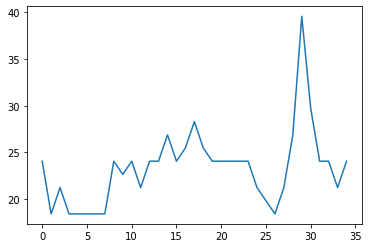

In [24]:
plt.plot(size)

In [ ]:
start_centroid

In [ ]:
trajectory_logger[1572.0]['timestamps'][-1]

In [ ]:
total_tracking = np.concatenate(list(tracks_logger.values()))
unique_ids, counts = np.unique(total_tracking[:, -1], return_counts=True)
indx = np.argsort(counts)
sorted_counts = np.sort(counts)

In [ ]:
# Only count tracks with more than 30 steps
valid_tracks = unique_ids[indx[sorted_counts > 15]].tolist()

In [ ]:
valid_tracks

In [ ]:
indx = 0
points = np.stack(trajectory_logger[valid_tracks[indx]]['bounding_boxes'])
temp = trajectory_logger[valid_tracks[indx]]['timestamps']
velocities = np.stack(trajectory_logger[valid_tracks[indx]]['velocities'])

In [ ]:
vel_mag = np.sqrt(velocities[:, 0]**2 + velocities[:, 1]**2)

In [ ]:
print("Ride time %.2f seconds" % (temp[-1] - temp[0]))

In [ ]:
m_pix = 1.65/((pd_dataframe["y1"] - pd_dataframe["y0"]).mean() * y_size)

In [ ]:
(vel_mag * 3) * m_pix

In [ ]:
c = np.linspace(0, 1, len(points))
_ = plt.scatter(points[:, 0], points[:, 1], c=vel_mag)
plt.quiver(points[:, 0], points[:, 1], 
           velocities[:, 0], velocities[:, 1], 
           color='b', units='xy', width=10, scale=0.5)
plt.xlim([0, x_size])
plt.ylim([0, y_size])
_ = plt.title("Ride Trajectory")

In [ ]:
# Overlay onto video
vid = cv2.VideoCapture("au-currumbin4k.stream.20200608T000955960.bbox.mp4")
fps = vid.get(cv2.CAP_PROP_FPS)
timestamps = [vid.get(cv2.CAP_PROP_POS_MSEC)]
calc_timestamps = [0.0]

frame_width = int(vid.get(3))
frame_height = int(vid.get(4))
size = (frame_width, frame_height)

save_vid = cv2.VideoWriter('test2.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         3, size)
    
tracks_mask = None
tracks_frame = None
valid_tracks_colours = np.random.randint(0, 255, (len(valid_tracks), 3))

for i in trange(pd_dataframe['frames_indx'].max(), leave=False):
    ret, frame = vid.read()

    if tracks_frame is None:
        tracks_mask = np.ones_like(frame)
        tracks_frame = np.zeros_like(frame)

    if i in tracks_logger.keys():
        tracks = tracks_logger[i]

        for track in tracks:
            if track[-1] in valid_tracks:
                center = np.array([track[0] + bb_x_size//2, track[1] + bb_y_size//2]).astype(int)
                track_indx = np.where(valid_tracks == track[-1])[0][0]
                color = valid_tracks_colours[track_indx].tolist()
                thickness = 10
                radius=30
                frame = cv2.circle(frame, center, radius, color, 3)
                
                arrow_start_point
                arrow_end_point
                frame = cv2.arrowedLine(frame, arrow_start_point, end_point,
                                     color, thickness) 

                start_point =  center + np.array([10, 15])
                end_point = center + np.array([-10, 15])
                tracks_mask = cv2.line(tracks_mask, start_point, end_point, (0, 0, 0), thickness) 
                tracks_frame = cv2.line(tracks_frame, start_point, end_point, color, thickness) 

    save_vid.write(frame * tracks_mask + tracks_frame)

vid.release()
save_vid.release()

In [ ]:
len(log_tracks)

In [ ]:
pd_dataframe['frames_indx'].max()

In [ ]:
tracks

In [ ]:
i

In [ ]:
len(log_tracks)